In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Background
GoalZone is a fitness club chain in Canada.
GoalZone offers a range of fitness classes in two capacities - 25 and 15. Some classes are always fully booked. Fully booked classes often have a low attendance rate. GoalZone wants to increase the number of spaces available for classes.
They want to do this by predicting whether the member will attend the class or not. If they can predict a member will not attend the class, they can make another spaceavailable.

In [61]:
df = pd.read_csv('fitness_class_2212.csv')
df.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


# Task 1

Undestanding the dataset

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


In [63]:
df.nunique()

booking_id          1500
months_as_member      72
weight              1241
days_before           31
day_of_week           10
time                   2
category               6
attended               2
dtype: int64

In [52]:
df['months_as_member'].max()

148

In [64]:
print(df['weight'].isna().sum())
df['weight'] = df['weight'].fillna(df['weight'].mean().round(2))
print(df['weight'].isna().sum())


20
0


In [60]:
print(df['weight'].min(), df['weight'].max())

55.41 170.52


In [65]:
print(df['days_before'].unique())
df['days_before'] = df['days_before'].str.replace(' days', '').astype(int)
print(df['days_before'].unique())


['8' '2' '14' '10' '6' '4' '9' '12' '5' '3' '7' '13' '12 days' '20' '1'
 '15' '6 days' '11' '13 days' '3 days' '16' '1 days' '7 days' '8 days'
 '10 days' '14 days' '17' '5 days' '2 days' '4 days' '29']
[ 8  2 14 10  6  4  9 12  5  3  7 13 20  1 15 11 16 17 29]


In [66]:
print(df['day_of_week'].unique())
df = df.replace({'day_of_week': {'Wednesday':'Wed', 'Monday':'Mon', 'Fri.':'Fri'}})
print(df['day_of_week'].unique())


['Wed' 'Mon' 'Sun' 'Fri' 'Thu' 'Wednesday' 'Fri.' 'Tue' 'Sat' 'Monday']
['Wed' 'Mon' 'Sun' 'Fri' 'Thu' 'Tue' 'Sat']


In [67]:
df['time'].unique()

array(['PM', 'AM'], dtype=object)

In [68]:
print(df['category'].value_counts())
df['category'] = df['category'].replace('-','unknown')
print(df['category'].value_counts())

category
HIIT        667
Cycling     376
Strength    233
Yoga        135
Aqua         76
-            13
Name: count, dtype: int64
category
HIIT        667
Cycling     376
Strength    233
Yoga        135
Aqua         76
unknown      13
Name: count, dtype: int64


In [69]:
df['attended'].unique()

array([0, 1], dtype=int64)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1500 non-null   float64
 3   days_before       1500 non-null   int32  
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 88.0+ KB


In [71]:
df.nunique()

booking_id          1500
months_as_member      72
weight              1241
days_before           19
day_of_week            7
time                   2
category               6
attended               2
dtype: int64

Summary of Data Validation and Cleaning

The original DataFrame has 1500 entries and 8 columns. After validation, the entries remain 1500. The following describes what i did to each column.

- booking_id: There were 1500 unique IDs, as described. There are no missing values for in this column. I did not make any changes to this column.
- months_as_member: The values matches the description as provided in the table. There are no missing values to treat. I did not make any changes to this column.
- weight: this is a continious variable with values rounded to 2 decimal places as described. It had a total missing value of 20. I used the overall average weight to replace all the missing values.
- days_before: this values did not match the description because it had a combination numeric values stored as objects and alpha-numeric values stored as object. It had no missing values. I striped the string ' days' from the values containing it first, then converted the column to an interger datatype to make it discrete.
- day_of_week: The values do not match the description provided in the table. There are no missing values. I replaced the values 'Wednesday', 'Fri.', and 'Monday' which was not provided in the description with the correct equivalent as provided in the description. 
- time: The values matches the description provided in the table. There are no missing values. I did not have to make any changes to this column.
- category: The values match the description provided in the table. There are a total of 13 missing values in the column represented with a '-' sign. I replaced these missing values with the value 'unknown'.
- attended: The values match the describtion provided in the table. The are no missing values. I did not have to make any changes to this column.

# Task 2

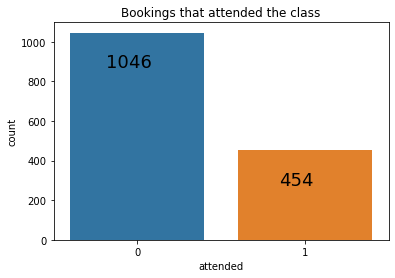

In [176]:
plot = sns.countplot(x='attended', data=df)
for a in plot.patches:
    plot.annotate(f'\n{a.get_height()}', (a.get_x()+0.35, a.get_height()), ha='center', va='top', color='black', size=18)
plot.set(title= 'Bookings that attended the class')
plt.show()

- The binary category 0 (not attended) has the most observation compared to binary category 1 (attended).
-  the Observations are not balanced across the categories because the value of 0 (not attended) is 1046, which is more than double the value of 1 (attended). 

# Task 3

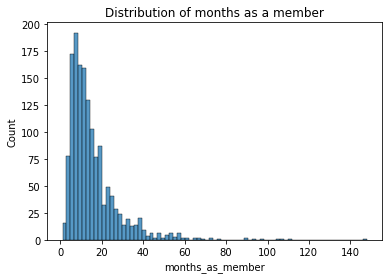

In [98]:
sns.histplot(x='months_as_member', data=df).set(title='Distribution of months as a member')
plt.show()

- We see from the distribution of of the months as members that most members are have joined for about 2 - 20 months

# Task 4

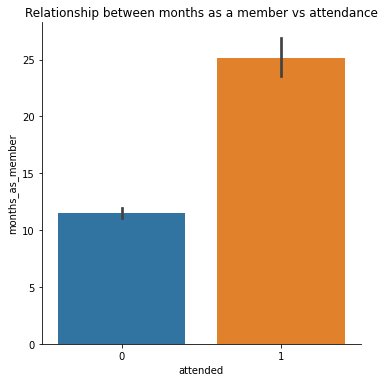

In [99]:
rel = sns.catplot(x='attended', y='months_as_member', data=df, kind='bar')
rel.set(title='Relationship between months as a member vs attendance')
plt.show()

[Text(0.5, 1.0, 'Relationship between months as a member vs attendance')]

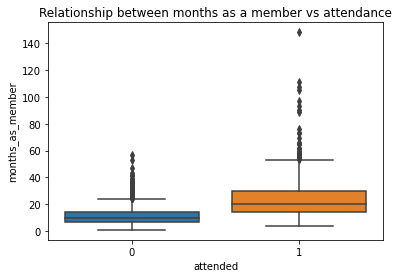

In [105]:
rel2 = sns.boxplot(x='attended', y='months_as_member', data=df)
rel2.set(title='Relationship between months as a member vs attendance')

- We see that on average the members who have been with the fitness club for longer periods tend to attend classes more than members with shorter periods.

# Task 5

This is a typical True or False machine learning problem that would require a classification model to make predictions.

# Task 6

Now I would be creating a baseline model to predict whether members will attend using the data provided. I would be using the LogisticRegression model as my baseline Model.

In [126]:
# Data Preprocessing
# Selecting the independent variables
features = df.drop(['booking_id', 'attended'], axis=1)

X = pd.get_dummies(features).values 
y = df['attended'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Modeling with a scaled data
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [164]:
# Calling a LogisticRegression model
logreg = LogisticRegression()
logreg.fit(X_scaled_train, y_train)
logreg_pred = logreg.predict(X_scaled_test)
logreg_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], d

# Task 7

I would be using Random Forest Classsifier as a comparison model to predict whether members will attend using the data provided.

In [162]:
# Calling a RandomForestClassifier model
rfcla = RandomForestClassifier()
rfcla.fit(X_scaled_train, y_train)
rfcla_pred = rfcla.predict(X_scaled_test)
rfcla_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], d

# Task 8

Why I used LogisticRegression Model?
- Logistic Regression is one of the easiest and accurate models for binary classification in terms of training the model to learn from the dataset. Using this as a baseline model helps set a benchmark for any other model. If they do not significantly outperform logistic regression, it suggests that the problem might not require the added complexity. 

Why I used RandomForestClassifier Model?
- As an ensemble method that combines the predictions of multiple decision trees, Random Forest Classifier can effectively deal with complex data relationships, handle outliers, achieving high accuracy, and deal with other complex metrix in just one model

# Task 9

I would be evaluating the performance for both LogisticRegression Model and RandomForestClassifier Model.

In [175]:
# Performance for LogisticRegression Model
print('The roc_auc_score for LogisticRegression Classifier:', roc_auc_score(y_test, logreg_pred).round(2))
print('Accuracy for LogisticRegression Classifier:', logreg.score(X_scaled_test, y_test).round(2))
print('Confusion Matrix for LogisticRegression Classifier: \n',  confusion_matrix(y_test, logreg_pred))
print('Classification Report for LogisticRegression Classifier: \n', classification_report(y_test, logreg_pred))

The roc_auc_score for LogisticRegression Classifier: 0.7
Accuracy for LogisticRegression Classifier: 0.78
Confusion Matrix for LogisticRegression Classifier: 
 [[187  10]
 [ 57  46]]
Classification Report for LogisticRegression Classifier: 
               precision    recall  f1-score   support

           0       0.77      0.95      0.85       197
           1       0.82      0.45      0.58       103

    accuracy                           0.78       300
   macro avg       0.79      0.70      0.71       300
weighted avg       0.79      0.78      0.76       300



In [174]:
# Performance for RandomForestClassifier Model
print('The roc_auc_score for RandomForestClassifier:', roc_auc_score(y_test, rfcla_pred).round(2))
print('Accuracy for RandomForestClassifier:', rfcla.score(X_scaled_test, y_test).round(2))
print('Confusion Matrix for RandomForestClassifier: \n',  confusion_matrix(y_test, rfcla_pred))
print('Classification Report for RandomForestClassifier: \n', classification_report(y_test, rfcla_pred))

The roc_auc_score for RandomForestClassifier: 0.7
Accuracy for RandomForestClassifier: 0.76
Confusion Matrix for RandomForestClassifier: 
 [[175  22]
 [ 51  52]]
Classification Report for RandomForestClassifier: 
               precision    recall  f1-score   support

           0       0.77      0.89      0.83       197
           1       0.70      0.50      0.59       103

    accuracy                           0.76       300
   macro avg       0.74      0.70      0.71       300
weighted avg       0.75      0.76      0.75       300



# Task 10

Which Model performs better?

The roc_auc_score of 0.70 for both Logistic Regression and Random Forest Classifier suggests that both models are good at distinguishing between positive and negative instances, regardless of the specific classification threshold chosen.

- However, The Logistic Regression performs better at prediction with this problem because it holds a higher accuracy score of 0.78 when compared to Random Forest Classifier with an accuracy score of 0.76.

From the Classification Report
- A higher pricision value for 1 (attended) in the Logistic Regression (0.82) than in Random Forest Classifier (0.70) means we have a lower false positive rate in our prediction with Logistic Regression. i.e fewer people who actually attend regularly would be tagged as absent.
- A higher recall value for 0 (not attended) in the Logistic Regression (0.95) than in Random Forest Classifier (0.89) means we have a lower false negative rate Logistic Regression. i.e we would be predicting most absent cases correctly